In [1]:
import numpy as np
from scipy.constants import degree
from FallingCat import FallingCat

import matplotlib.pyplot as plt
import numpy as np

params = {
    "figure.figsize": (6, 4),
    "figure.dpi": 72,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "font.size": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "savefig.bbox": "tight",
    "figure.constrained_layout.use": True,
}
plt.rcParams.update(params)

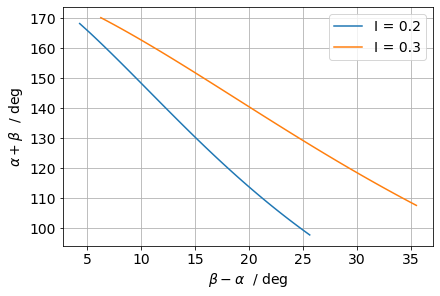

In [2]:
JI = [0.2, 0.3]
alpha = np.linspace(36, 82, 50) * degree

# plt.figure(figsize=(5,3.75))

for j in JI:
    beta, c = [], None
    for a in alpha:
        c = FallingCat(j, a, init=c)
        beta.append(c.beta)

    ba = (beta - alpha) / degree
    ab = (alpha + beta) / degree
    plt.plot(ba, ab, label="I = %g" % j)

plt.legend()
plt.xlabel(r"$\beta - \alpha$  / deg")
plt.ylabel(r"$\alpha + \beta$  / deg")
plt.grid()
plt.show()

-389.20128620831855
94.61881464893823
34.61881464893822


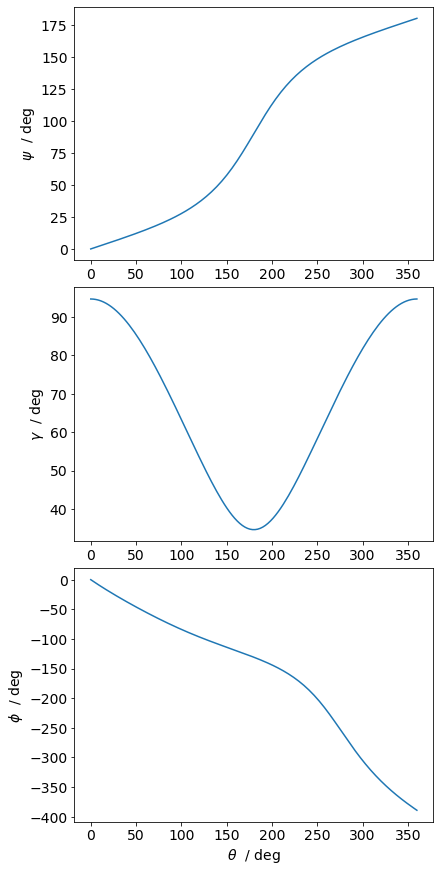

In [ ]:
JI = 0.25
alpha = 30 * degree

plt.figure(figsize=(6, 12))

c = FallingCat(JI, alpha)
t = c.theta / degree
psi = c.lean() / degree
gamma = c.bend() / degree
phi = c.twist() / degree
print(phi[-1])
print((c.alpha + c.beta) / degree)
print((c.beta - c.alpha) / degree)

plt.subplot(3, 1, 1)
plt.plot(t, psi)
plt.ylabel(r"$\psi$  / deg")

plt.subplot(3, 1, 2)
plt.plot(t, gamma)
plt.ylabel(r"$\gamma$  / deg")

plt.subplot(3, 1, 3)
plt.plot(t, phi)
plt.ylabel(r"$\phi$  / deg")

plt.xlabel(r"$\theta$  / deg")
plt.show()

64.61881464893823
[1.65140985 1.19048259 0.6042123  1.19048259 1.65140985]
[ 0.         -1.34382245 -2.28447539 -4.20624253 -6.7928439 ]
[0.         0.41726472 1.57079633 2.72432793 3.14159265]


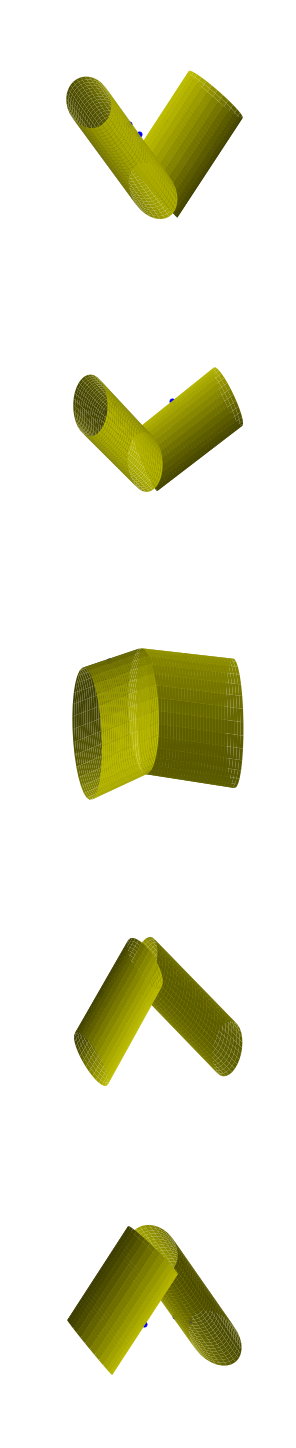

In [8]:
JI = 0.25
alpha = 30 * degree
theta = np.linspace(0, 2 * np.pi, 5)

c = FallingCat(JI, alpha)

print(c.beta / degree)
print(c.bend(theta))
print(c.twist(theta))
print(c.lean(theta))

plt.figure(figsize=(6, 4 * 5))

for i, th in enumerate(theta):
    plt.subplot(5, 1, i + 1, projection="3d")
    ax = c.plot(th, color="y", leg_color=".b", ms=10)
    ax.view_init(15, -15)
    ax.set_axis_off()
    # ax.autoscale(False)
#    ax.set_xlim(-4,4)
#    ax.set_ylim(-4,4)
#    ax.set_zlim(-4,4)
#    ax.axis('equal')

plt.show()